## Part 3 - Bikeshare Dataset Project

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
%reload_ext google.cloud.bigquery

### What are the three most popular trips overall?

In [95]:
! bq query --use_legacy_sql=false 'SELECT COUNT(*) as count, start_station_name, end_station_name \
FROM `innate-mapper-287722.bike_trip_data.trips_all` \
WHERE start_station_name != end_station_name \
GROUP BY start_station_name, end_station_name \
ORDER BY count DESC \
LIMIT 3'

Waiting on bqjob_r447ec2f60893f375_00000174e4a8032b_1 ... (0s) Current status: DONE   
+-------+-----------------------------------------+--------------------------------------+
| count |           start_station_name            |           end_station_name           |
+-------+-----------------------------------------+--------------------------------------+
|  9150 | Harry Bridges Plaza (Ferry Building)    | Embarcadero at Sansome               |
|  8508 | San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                      |
|  7620 | 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building) |
+-------+-----------------------------------------+--------------------------------------+


### What are the 5 most popular trips that you would call "commuter trips"?
  

Exploring the dataset, one notices that a large number of the trips certain around hours when people tend to commute to and from work. This can be seen in the table below.

In [98]:
! bq query --use_legacy_sql=false ' \
SELECT COUNT(*) as count, EXTRACT(HOUR from start_date) as hour \
FROM `innate-mapper-287722.bike_trip_data.trips_all` \
GROUP BY hour \
ORDER BY count DESC\
LIMIT 5'

Waiting on bqjob_r5130cb70d61298a1_00000174e4b07f42_1 ... (0s) Current status: DONE   
+--------+------+
| count  | hour |
+--------+------+
| 132464 |    8 |
| 126302 |   17 |
|  96118 |    9 |
|  88755 |   16 |
|  84569 |   18 |
+--------+------+


Given these times centered around commute times, the most popular "commuter trips" between two stations can be seen below with their respective count.

In [114]:
%%bigquery --use_rest_api commute_trips

SELECT COUNT(*) as count, start_station_name, end_station_name
FROM `innate-mapper-287722.bike_trip_data.trips_all`
WHERE start_station_name != end_station_name AND 
EXTRACT(HOUR FROM start_date)=8 OR
EXTRACT(HOUR FROM start_date)=9 OR
EXTRACT(HOUR FROM start_date)=16 OR
EXTRACT(HOUR FROM start_date)=17 OR
EXTRACT(HOUR FROM start_date)=18
GROUP BY start_station_name, end_station_name
ORDER BY count DESC
LIMIT 5

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [115]:
commute_trips

,count,start_station_name,end_station_name
0,5213,2nd at Townsend,Harry Bridges Plaza (Ferry Building)
1,4884,Embarcadero at Sansome,Steuart at Market
2,4592,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
3,4522,Harry Bridges Plaza (Ferry Building),2nd at Townsend
4,4486,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th)


### Weekend trips and weekday trips

A significantly larger number of trips occur at 8 am and 5pm, as well during the hours around these times. Since most people work on weekdays, however, there could exist a difference in the distribution of trips throughout the day between weekdays and weekends. To explore that, I create two datasets containing weekend trips and weekday trips and plot the distribution of trips throughout the day.

In [85]:
%%bigquery --use_rest_api trip_times_weekdays

SELECT COUNT(*) as count, EXTRACT(HOUR from start_date) as hour
FROM `innate-mapper-287722.bike_trip_data.bike_trips_weekdays`
GROUP BY hour
ORDER BY count DESC

In [88]:
%%bigquery --use_rest_api trip_times_weekends

SELECT COUNT(*) as count, EXTRACT(HOUR from start_date) as hour
FROM `innate-mapper-287722.bike_trip_data.bike_trips_weekends`
GROUP BY hour
ORDER BY count DESC

Here is the SQL for the tables 'bike_trips_weekdays' and 'bike_trips_weekends'

#### bike_trips_weekdays
```
SELECT *
FROM `innate-mapper-287722.bike_trip_data.trips_all`
WHERE EXTRACT(DAYOFWEEK FROM start_date)<=5
````
#### bike_trips_weekends
```
SELECT *
FROM `innate-mapper-287722.bike_trip_data.trips_all`
WHERE EXTRACT(DAYOFWEEK FROM start_date)>5
```

Text(0.5, 1.0, 'Distribution of trips in weekends')

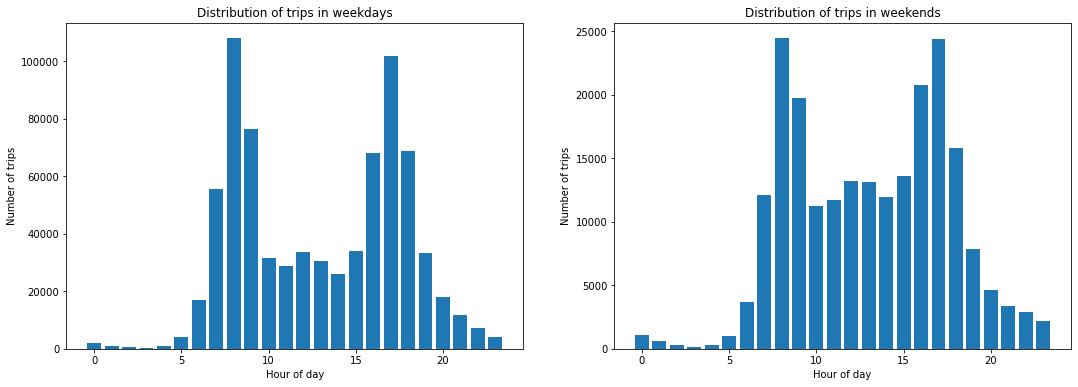

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].bar(trip_times_weekdays['hour'], trip_times_weekdays['count'])
ax[0].set_ylabel('Number of trips')
ax[0].set_xlabel('Hour of day')
ax[0].set_title('Distribution of trips in weekdays')

ax[1].bar(trip_times_weekends['hour'], trip_times_weekends['count'])
ax[1].set_ylabel('Number of trips')
ax[1].set_xlabel('Hour of day')
ax[1].set_title('Distribution of trips in weekends')

As we can see from the plots above, during weekdays there are more trips centered around the two peak hours, 8am and 5pm (when people tend to commute). During weekends, however, the distribution around these aforementioned times is not as distinct (compared to weekdays). Though there still exists a "slump" from 9am to 4pm, there seem to be proportionally more trips during the afternoon hours on weekends.

In order to understand the distribution of trips throughout the week, I create the following dataset and then visualize the number of trips per day.

In [9]:
%%bigquery --use_rest_api trips_by_day

SELECT COUNT(*) as ct, day AS day FROM(
SELECT CASE
WHEN day=1 THEN "Sunday" WHEN day=2 THEN "Monday"
WHEN day=3 then "Tuesday" WHEN day=4 THEN "Wednesday"
WHEN day=5 THEN "Thursday" WHEN day=6 THEN "Friday"
WHEN day=7 THEN "Saturday" END AS day FROM
(SELECT EXTRACT(DAYOFWEEK FROM start_date AT TIME ZONE "UTC") AS day
FROM `bigquery-public-data.san_francisco.bikeshare_trips`))
GROUP BY day

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


Text(0.5, 1.0, 'Total number of trips by day of the week')

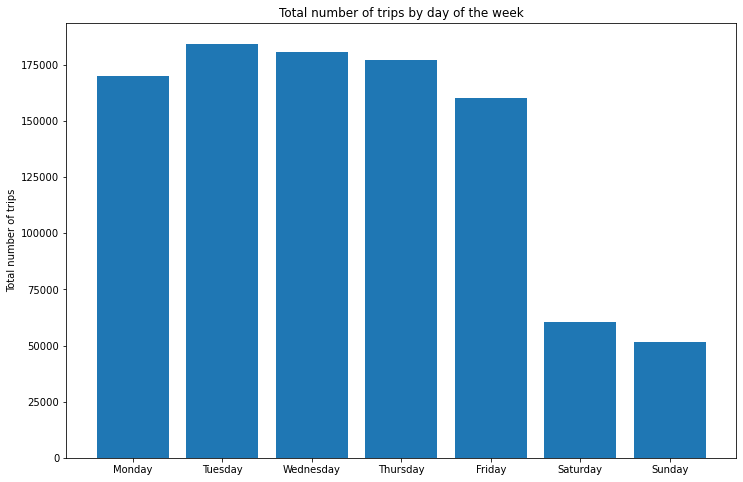

In [39]:
trips_by_day['day_id'] = [4,7,5,2,6,1,3]
trips_by_day.sort_values('day_id')
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(trips_by_day['day_id'], trips_by_day['ct'])
ax.set_xticks([x for x in trips_by_day['day_id']])
ax.set_xticklabels(trips_by_day['day'])
ax.set_ylabel('Total number of trips')
ax.set_title('Total number of trips by day of the week')

As we can see in the plot above, trips happening in the weekend are significantly lower compared to trips happening on weekdays. This could indicate that a large proportion of the trips are for commuting purposes.

### Subscribers vs. Customers

To explore how many bike trips are done by customers and how many by subscribers, I create the following dataset, process it, and plot it accordingly.

In [43]:
%%bigquery --use_rest_api subscribers_vs_customers

SELECT COUNT(*) as count, EXTRACT(DAYOFWEEK FROM start_date) as day, subscriber_type as type_of_customer
FROM `innate-mapper-287722.bike_trip_data.trips_all`
GROUP BY day, type_of_customer
ORDER BY day

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [59]:
#subscribers_vs_customers
customers = [0,0]
subscribers = [0,0]
for i in range(len(subscribers_vs_customers)):
    if subscribers_vs_customers.iloc[i]['day']<=5 and subscribers_vs_customers.iloc[i]['type_of_customer']=='Subscriber':
        subscribers[0] += subscribers_vs_customers.iloc[i]['count']
    elif subscribers_vs_customers.iloc[i]['day']>5 and subscribers_vs_customers.iloc[i]['type_of_customer']=='Subscriber':
        subscribers[1] += subscribers_vs_customers.iloc[i]['count']
    elif subscribers_vs_customers.iloc[i]['day']<=5 and subscribers_vs_customers.iloc[i]['type_of_customer']=='Customer':
        customers[0] += subscribers_vs_customers.iloc[i]['count']
    else:
        customers[1] += subscribers_vs_customers.iloc[i]['count']

Text(0, 0.5, 'Number of trips')

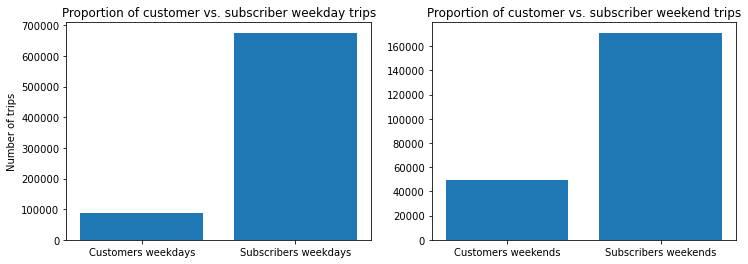

In [77]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(['Customers weekdays', 'Subscribers weekdays'],[customers[0],subscribers[0]])
ax[0].set_title('Proportion of customer vs. subscriber weekday trips')
ax[1].bar(['Customers weekends', 'Subscribers weekends'],[customers[1],subscribers[1]])
ax[1].set_title('Proportion of customer vs. subscriber weekend trips')
ax[0].set_ylabel('Number of trips')

As we can see in the plot above, there are relatively more customer trips happening on weekends. Given the data from the plots before, this might mean that individuals that commute more tend to be subscribers while individuals who rent bikes for leisure do so more during the weekend. There is no high incentive for leisure riders to buy subscriptions since they do not use the bikes on a daily basis. There is, however, a market that could be explored. 

### Tourists and Visitors

Another market that could be explored is that of tourists and visitors. The San Francisco Travel Association reported [25.8 million tourists visited San Francisco in 2018](https://www.sftravel.com/article/san-francisco-travel-reports-record-breaking-tourism-levels-2018-gives-projections-2019#:~:text=San%20Francisco%20Travel%20is%20reporting,over%2025.5%20million%20in%202017.). Some of the most popular tourist and commercial attractions in San Francisco can be found in the Embarcadero and North Beach area, such as the Ferry Building, the Piers, various museums (such as the Exploratorium), and Fisherman's Wharf. This is somewhat reflected in the most popular trips table especially when we filter the data to get weekend data (as shown below).

In [112]:
! bq query --use_legacy_sql=false 'SELECT COUNT(*) as count, start_station_name, end_station_name \
FROM `innate-mapper-287722.bike_trip_data.trips_all` \
WHERE start_station_name != end_station_name \
AND EXTRACT(DAYOFWEEK FROM start_date)>5 \
GROUP BY start_station_name, end_station_name \
ORDER BY count DESC \
LIMIT 5'

Waiting on bqjob_r3996c6ee0842d931_00000174e4f971ee_1 ... (0s) Current status: DONE   
+-------+------------------------------------------+--------------------------------------+
| count |            start_station_name            |           end_station_name           |
+-------+------------------------------------------+--------------------------------------+
|  2663 | Harry Bridges Plaza (Ferry Building)     | Embarcadero at Sansome               |
|  1603 | 2nd at Townsend                          | Harry Bridges Plaza (Ferry Building) |
|  1594 | San Francisco Caltrain 2 (330 Townsend)  | Townsend at 7th                      |
|  1501 | San Francisco Caltrain (Townsend at 4th) | Harry Bridges Plaza (Ferry Building) |
|  1419 | Embarcadero at Sansome                   | Steuart at Market                    |
+-------+------------------------------------------+--------------------------------------+


As we see, the most popular trip is from the Ferry Building to Embarcadero at Sansome. Another popular trip is 2nd at Townsend to Ferry Building. It should be taken into account that 2nd at Townsend is in close proximity to Oracle Park which hosts the San Francisco Giants team. Many gamegoers might choose bike as their preferred means of transportation, possibly explaining some of the data.

## Proposals

Given the data above, I propose the following subscription offers are adopted.

### Weekend Rider Subscription

Since there is no incentive for leisure riders to subscribe, the company could create weekend subscriptions, at a lower price than normal subscriptions that will allow individuals to have a number of bike rides during the weekend. This could benefit all types of leisure riders, such as the aforementioned gamegoers, who use the bikes often but are not willing to commit to a monthly or a yearly subscription. For comparison purposes, a monthly subscription costs 15 dollars while a yearly subscription costs 149 dollars. A weekend subscription could cost around 5 dollars per month.

### Commuter Subscription

Analogously to how leisure riders might want to escape paying for monthly subscriptions because they do not use the bikes during weekdays, commuters might not want to pay for weekend trips. An option to consider could, thus, be to release a Commuter Subscription that does not cover weekends but comes at a reduced price compared to the current rates.

### Visitor Pass

Given the large number of individuals that visit San Francisco every year, it could potentially be a good option to create Visitor Passes that will both benefit the company and the customers in terms of pricing. A good way to implement that would be to create a system that allows individuals to input the numbers of days they will be visiting and gives them the option of buying a discounted pass for that number of days.

### Weekend "Happy Hours"

The most striking of the patterns in the data is the huge difference in the number of weekend trips compared to weekday trips. It could, therefore, make an important difference in revenues if the company were to seek ways to incentivize people to use the bikes during the weekend. For this, I propose that they implement a system of "Happy Hours" during low demand hours (mostly in the afternoon) in the weekend. At that time, bikes could be offerred at lower prices or a "1+1" scheme could be implemented where customers can unlock a second bike for free.